<ul>
    <li style='width:45%;display:inline-block'>
        <h1>PUG meeting</h1>
        <br><br><br><br><br><br><br><br><br><br><br><br>
        <h3>17/10/2019</h3>
        <h3>Josué Martínez Moreno</h3>
    </li>
    <li style='width:45%;display:inline-block'>
        <img src="./figures/how2writecode.png" alt="" style="width: 100%;"/>
    </li>
</ul>

# TrackEddy

In [1]:
# Import libraries 

import xarray  as xr
import numpy   as np
import pylab   as plt
import cmocean as cm

# Import TrackEddy
from trackeddy.tracking import *
from trackeddy.plotfunc import *

## Motivation:
<ul>
    <li style='width:45%;display:inline-block'>
        <img src="./figures/energy_diagram.png" alt="Ocean Model Energy" style="width: 100%;"/>
        <h5>Energy budget of an ocean model - Hughes et al. (2009)</h5>
    </li>
    <li style='width:45%;display:inline-block'>
        <img src="./figures/EKE_trend.png" alt="EKE Southern Ocean Trend" style="width: 100%;"/>
        <h5>EKE anomaly trend for three Southern Ocean sectors - Hogg et al. (2015)</h5>
    </li>
</ul>

# Load data

In [2]:
# Load Data
filepath = '/g/data/ua8/CMEMS_SeaLevel/v4-0/2016/dt_global_allsat_phy_*.nc'

In [3]:
# Open netcdf Dataset.
dataset = xr.open_mfdataset(filepath,parallel=True)

In [4]:
# Load data into memory
sla=dataset.sla.isel(time=slice(0,2)).values
lon=dataset.longitude.values
lat=dataset.latitude.values

# TrackEddy setup

In [5]:
# Define area of study
areamap = np.array([[0,len(lon)],[0,len(lat)]]) # Global option

In [6]:
# Time and spatial filter
filters = {'time':{'type':None,'t':None,'t0':None,'value':None},
           'spatial':{'type':'moving','window':50,'mode':'uniform'}}

# Mesoscale scaling 
checkarea={'mesoscale':2*np.pi}

# Eddy definition criteria
preferences={'ellipse':0.85,'eccentricity':0.85,'gaussian':0.8}

In [7]:
# Levels to be analysed and to extract positive eddies from anomaly
levels_pos = {'max':np.nanmax(sla[0,:,:]),'min':0.01,'step':0.01}

In [8]:
# Levels to be analysed and to extract negative eddies from anomaly
levels_neg = {'max':np.nanmin(sla[0,:,:]),'min':-0.01,'step':-0.01}

# Execute TrackEddy main function

In [9]:
# Warm core eddies identification
positive_eddies=analyseddyzt(sla,lon,lat,0,1,1,levels_pos,preferences=preferences
             ,areamap=areamap,areaparms=checkarea,filters=filters,timeanalysis='none'
             ,maskopt='contour',diagnostics=False,pprint=True)

 0% [==========>]100% | Elapsed Time: 0 s | Estimated Time: 0 s | Info: Init time |
 0% [==========>]100% | Elapsed Time: 419 s | Estimated Time: 419 s | Info: # of E 18280 ||


In [10]:
# Cold core eddies identification
negative_eddies=analyseddyzt(sla,lon,lat,0,1,1,levels_neg,preferences=preferences
             ,areamap=areamap,areaparms=checkarea,filters=filters,timeanalysis='none'
             ,maskopt='contour',diagnostics=False,pprint=True)

 0% [==========>]100% | Elapsed Time: 0 s | Estimated Time: 0 s | Info: Init time |
 0% [==========>]100% | Elapsed Time: 510 s | Estimated Time: 510 s | Info: # of E 19613 ||


# Algorithm description

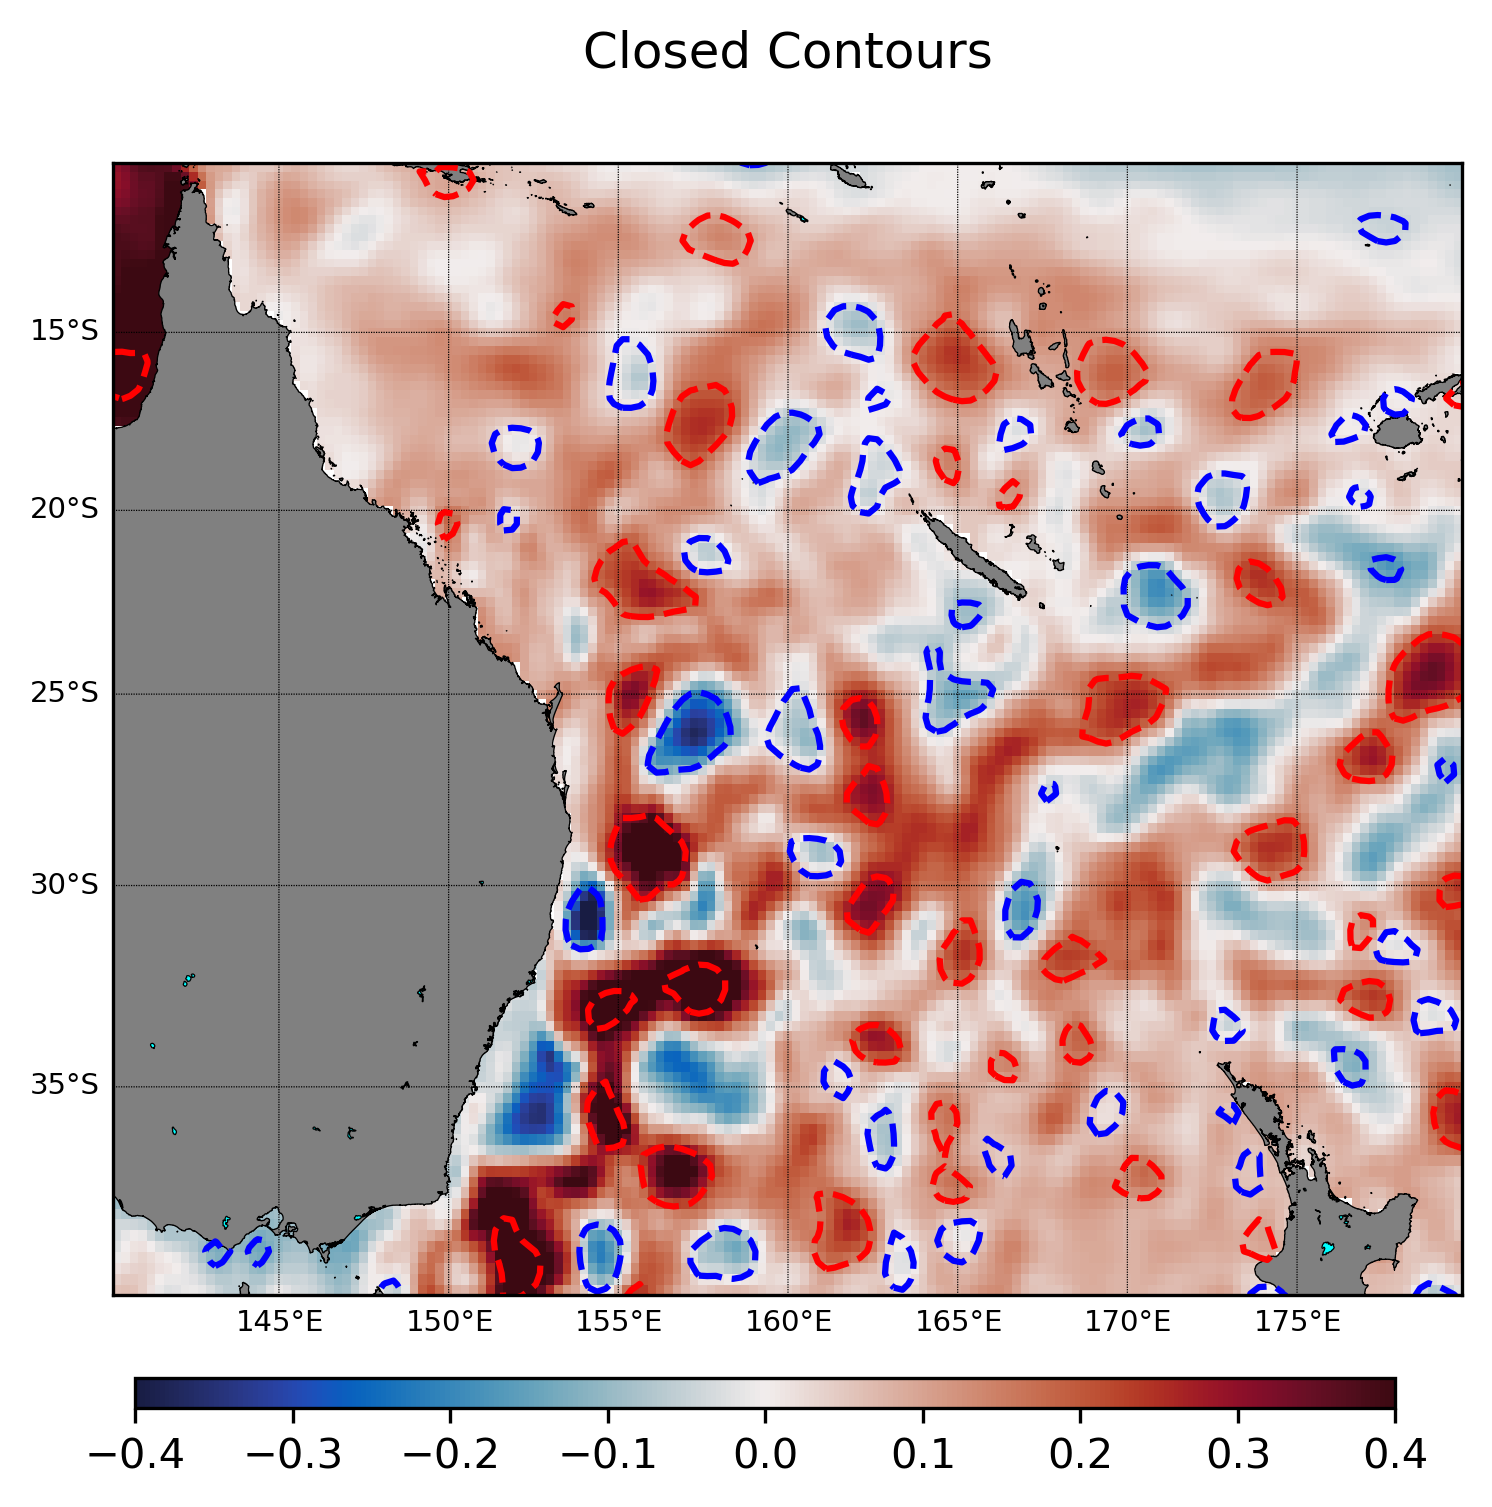

In [13]:
slice_adt = dataset.sla.isel(time=0).sel({'longitude':slice(140,180),'latitude':slice(-40,-10)})
fig,vel,ax,m=basemap_mplot(slice_adt.longitude,slice_adt.latitude,slice_adt,
              title="Closed Contours",projection='merc',freq=(5,5),
              lat_0=-90,lon_0=-180,resolution='f',vmin=-0.40,vmax=0.40,
              cmap=cm.cm.balance,xan=1,yan=1,figsize=(6,5),fontsize=12,drawlinewidth=0.3)

for key,item in negative_eddies.items():
    cx,cy=m(item['contour'][0][0],item['contour'][0][1])
    plt.plot(cx,cy,'--b')
    
for key,item in positive_eddies.items():
    cx,cy=m(item['contour'][0][0],item['contour'][0][1])
    plt.plot(cx,cy,'--r')

cbar_ax = fig.add_axes([0.15, 0.05, 0.70, 0.02])
fig.colorbar(vel[0], cax=cbar_ax,orientation='horizontal')
plt.savefig('./figures/E_australia_c.pdf',dpi=300)

<img src="./figures/E_australia_c.pdf" alt="East Australian eddies" style="width: 70%;"/>

Trackeddy is an algorithm which identifies and tracks eddies assuming that their outer most contours is well fitted by an ellipse (A. Fernandes and S. Nascimento, (2006))

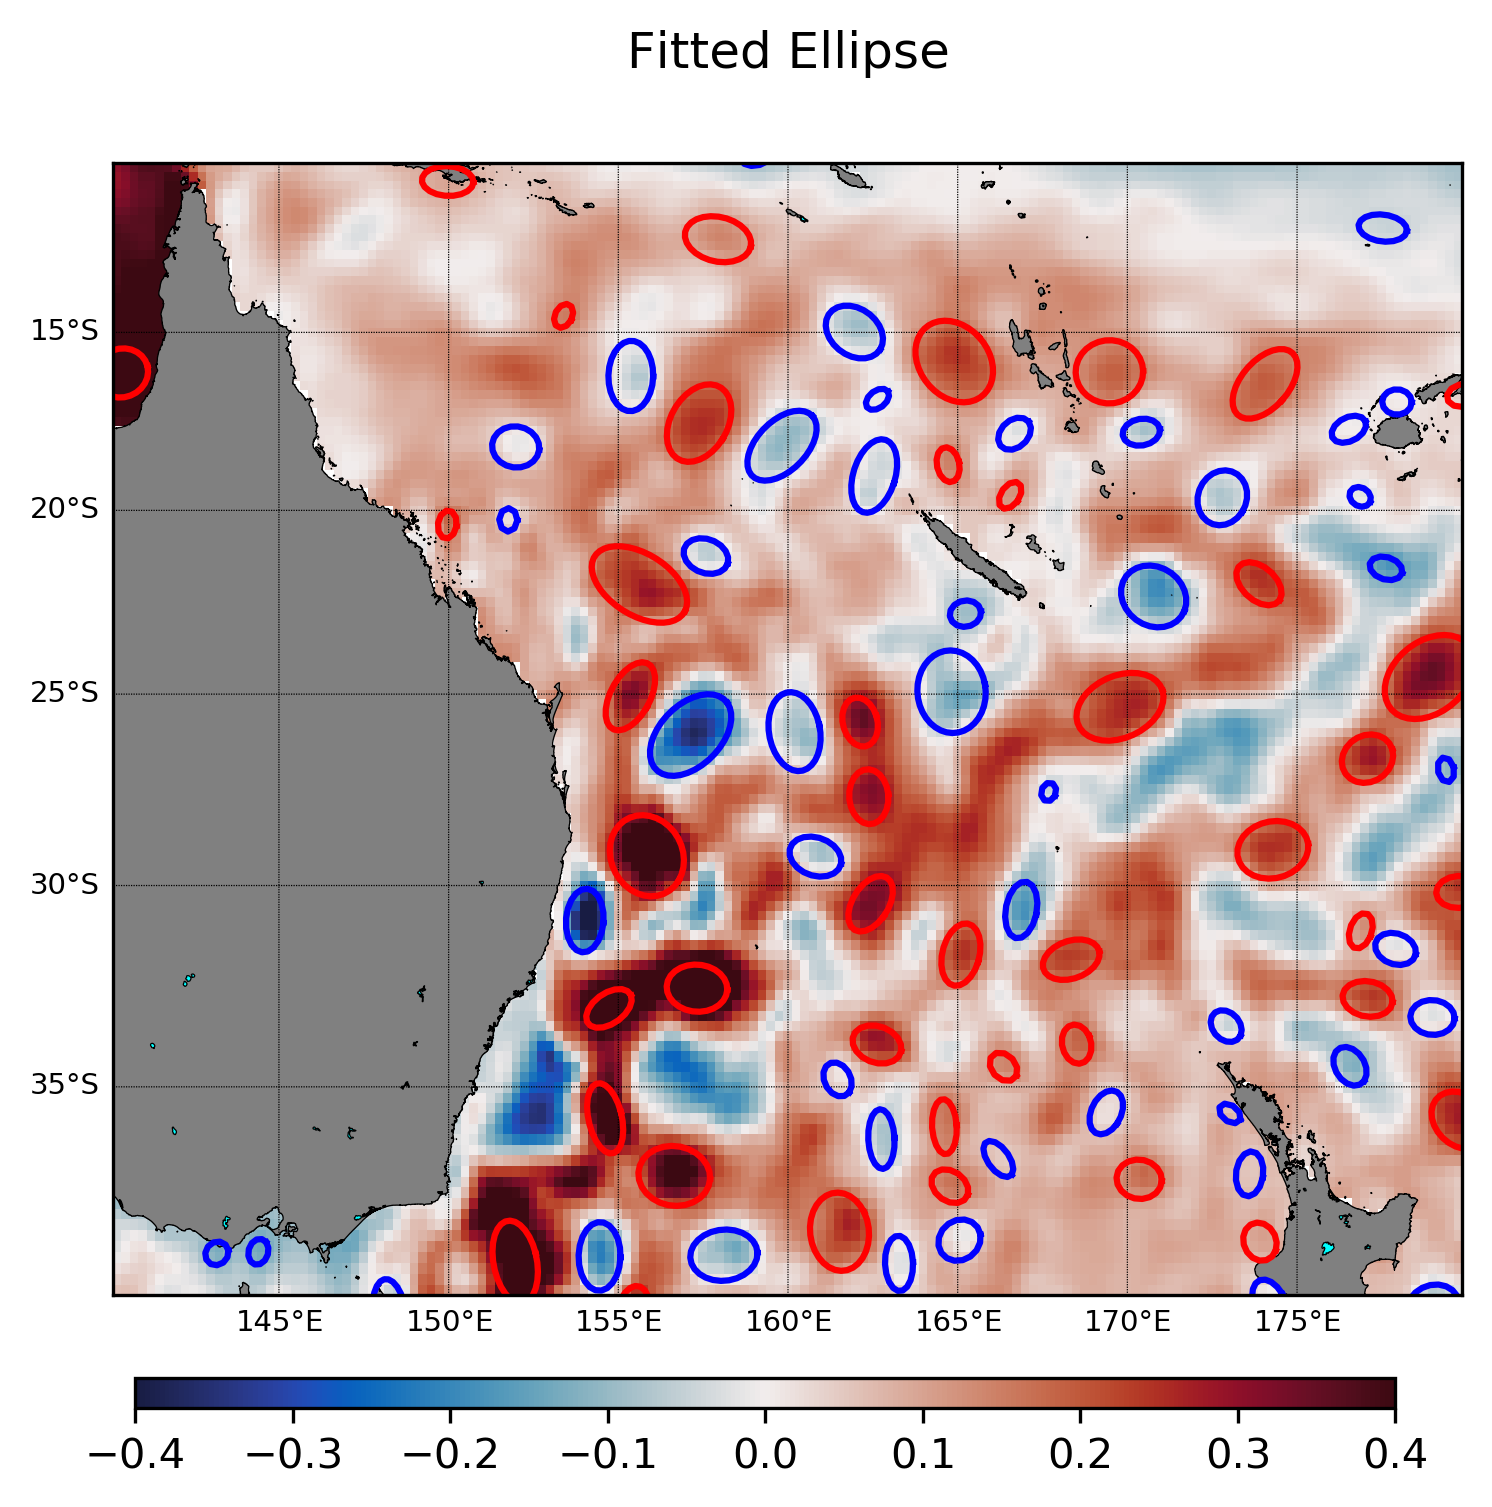

In [15]:
slice_adt = dataset.sla.isel(time=0).sel({'longitude':slice(140,180),'latitude':slice(-40,-10)})
fig,vel,ax,m=basemap_mplot(slice_adt.longitude,slice_adt.latitude,slice_adt,
              title="Fitted Ellipse",projection='merc',freq=(5,5),
              lat_0=-90,lon_0=-180,resolution='f',vmin=-0.40,vmax=0.40,
              cmap=cm.cm.balance,xan=1,yan=1,figsize=(6,5),fontsize=12,drawlinewidth=0.3)

for key,item in negative_eddies.items():
    ex,ey=m(item['ellipse'][0][0],item['ellipse'][0][1])
    plt.plot(ex,ey,'-b')
    
for key,item in positive_eddies.items():
    ex,ey=m(item['ellipse'][0][0],item['ellipse'][0][1])
    plt.plot(ex,ey,'-r')

cbar_ax = fig.add_axes([0.15, 0.05, 0.70, 0.02])
fig.colorbar(vel[0], cax=cbar_ax,orientation='horizontal')
plt.savefig('./figures/E_australia_e.pdf',dpi=300)

<img src="./figures/E_australia_e.pdf" alt="East Australian eddies" style="width: 70%;"/>

The area of the eddy contour should be smaller than  the first baroclinic Rossby Radius of Deformation (**Mesoscale Scaling**) defined as:
\begin{equation}
 2\pi L_r
\end{equation}
(Klocker, A., & Abernathey, R. (2014)).

To avoid the detection of meanders (jets), and due to the coherience of eddies, the **eccentricity** of the fitted ellipse eddies should be smaller than 
\begin{equation}
\frac{b}{2a}
\end{equation}
which qualitatively corresponds to a semi-major axis two times larger than the semi-minor axis.

#### The novelty of this algorithm is its capability to reconstruct the mesoscale eddy field from global SSHa by fitting optimal anisotropic Gaussians to each identified eddies.

# Reconstruct eddies

In [16]:
positive_eddy_field=reconstruct_syntetic(np.shape(sla),lon,lat,positive_eddies)

 0% [==========>]100% | Elapsed Time: 32 s | Estimated Time: 32 s | Info: eddyn_1143 |


In [17]:
negative_eddy_field=reconstruct_syntetic(np.shape(sla),lon,lat,negative_eddies)

 0% [==========>]100% | Elapsed Time: 33 s | Estimated Time: 33 s | Info: eddyn_1236 |


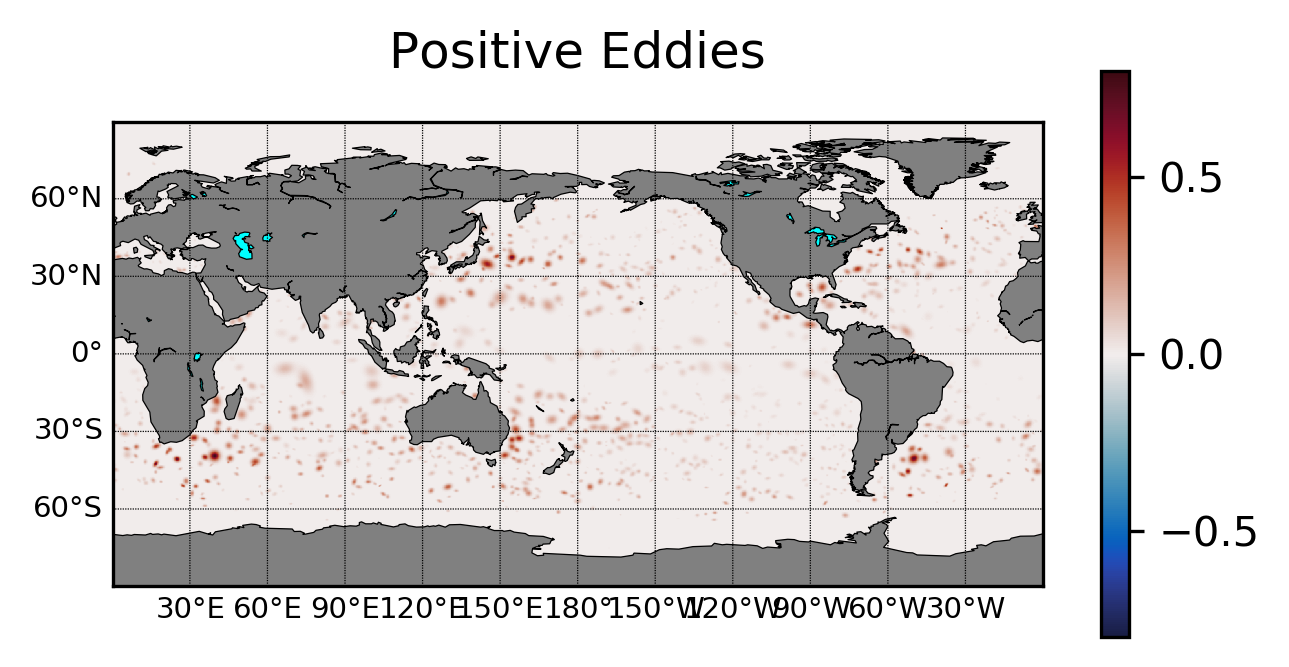

In [18]:
basemap_mplot(lon,lat,positive_eddy_field[0,:,:],title="Positive Eddies",projection='cyl',
              lat_0=-90,lon_0=-180,resolution='c',vmin=-0.80,vmax=0.80,
              cmap=cm.cm.balance,xan=1,yan=1,figsize=(5,2.5),fontsize=12,drawlinewidth=0.3)
plt.colorbar();

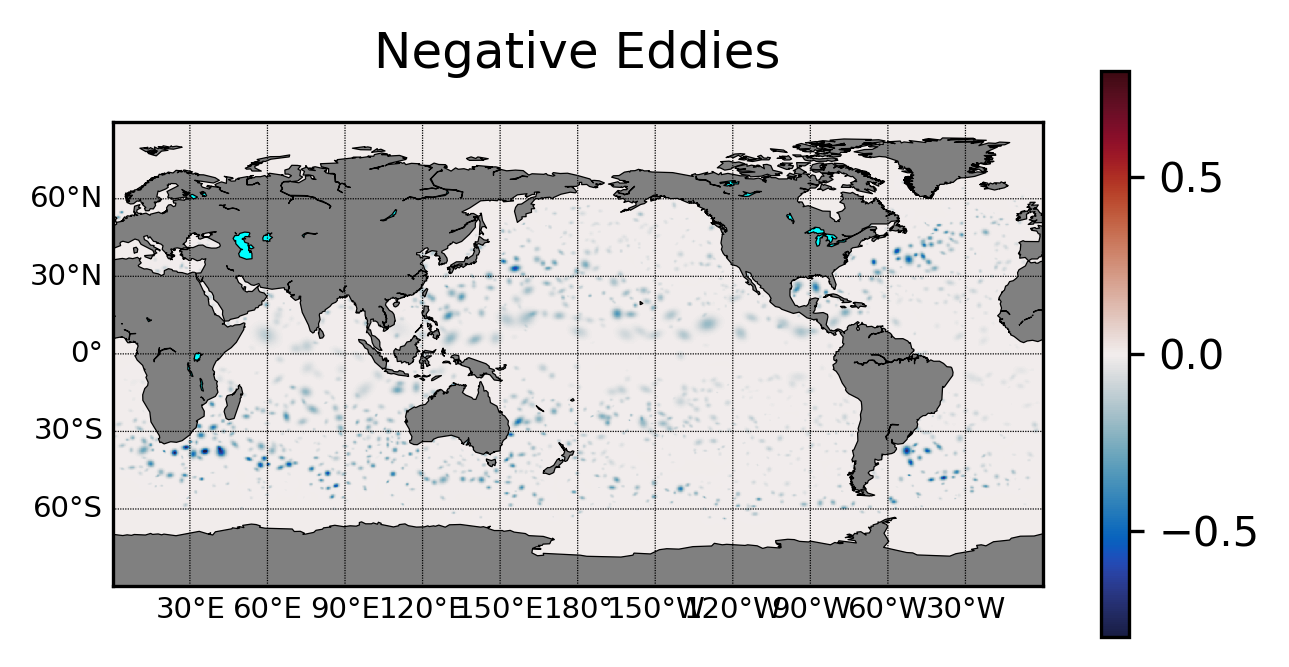

In [19]:
basemap_mplot(lon,lat,negative_eddy_field[0,:,:],title="Negative Eddies",projection='cyl',
              lat_0=-90,lon_0=-180,resolution='c',vmin=-0.80,vmax=0.80,
              cmap=cm.cm.balance,xan=1,yan=1,figsize=(5,2.5),fontsize=12,drawlinewidth=0.3)
plt.colorbar();

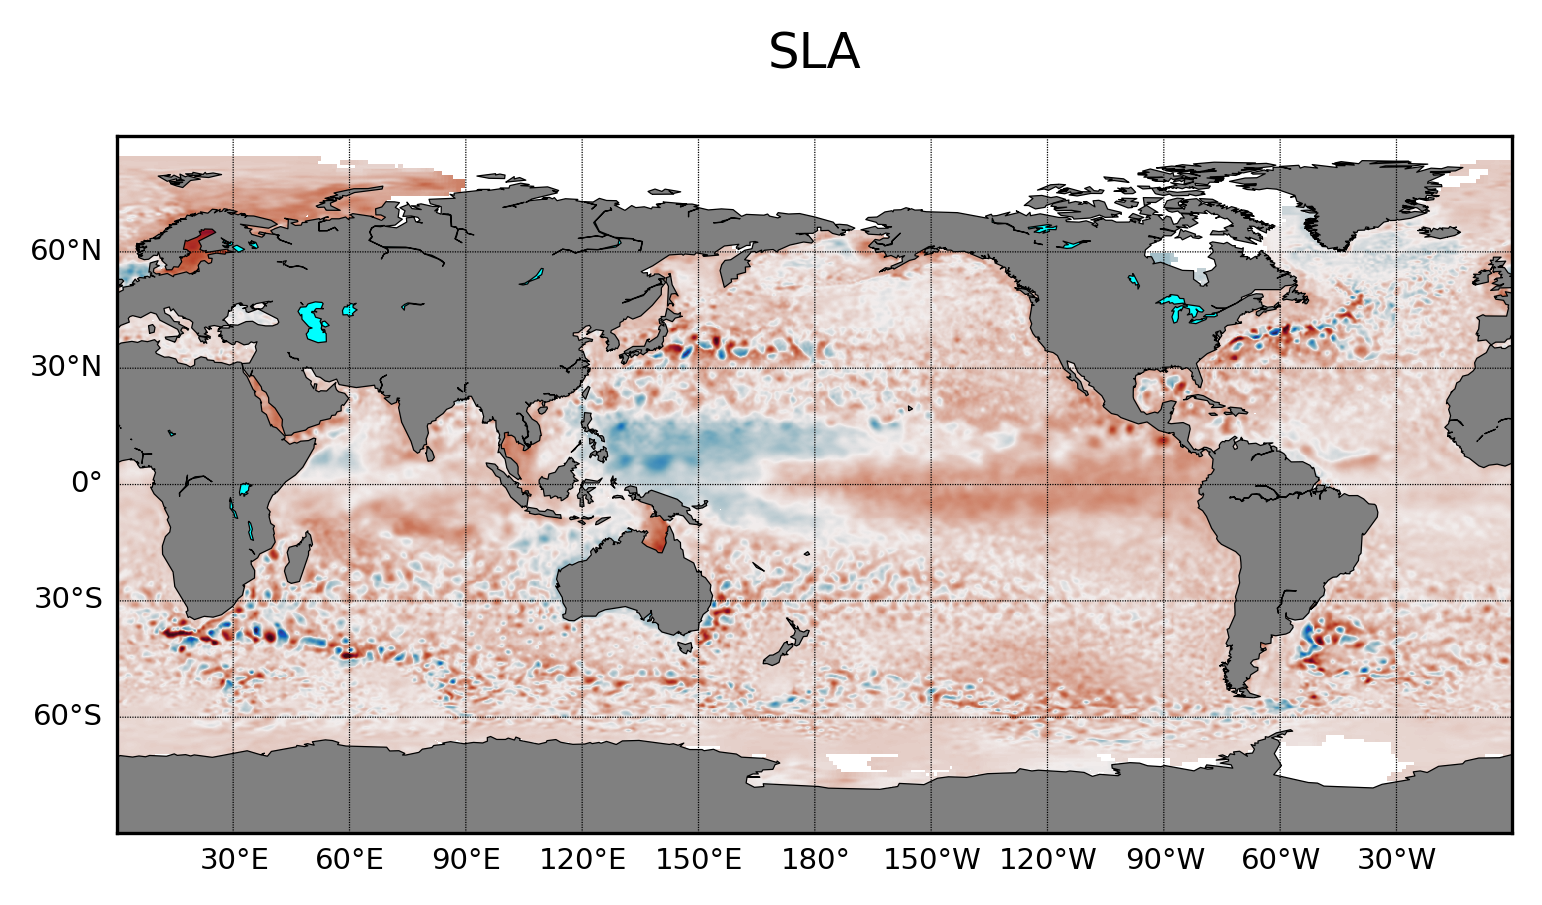

In [20]:
basemap_mplot(lon,lat,sla[0,:,:],
              title="SLA",projection='cyl',
              lat_0=-90,lon_0=-180,resolution='c',vmin=-0.80,vmax=0.80,
              cmap=cm.cm.balance,xan=1,yan=1,figsize=(6,6),fontsize=12,drawlinewidth=0.3);

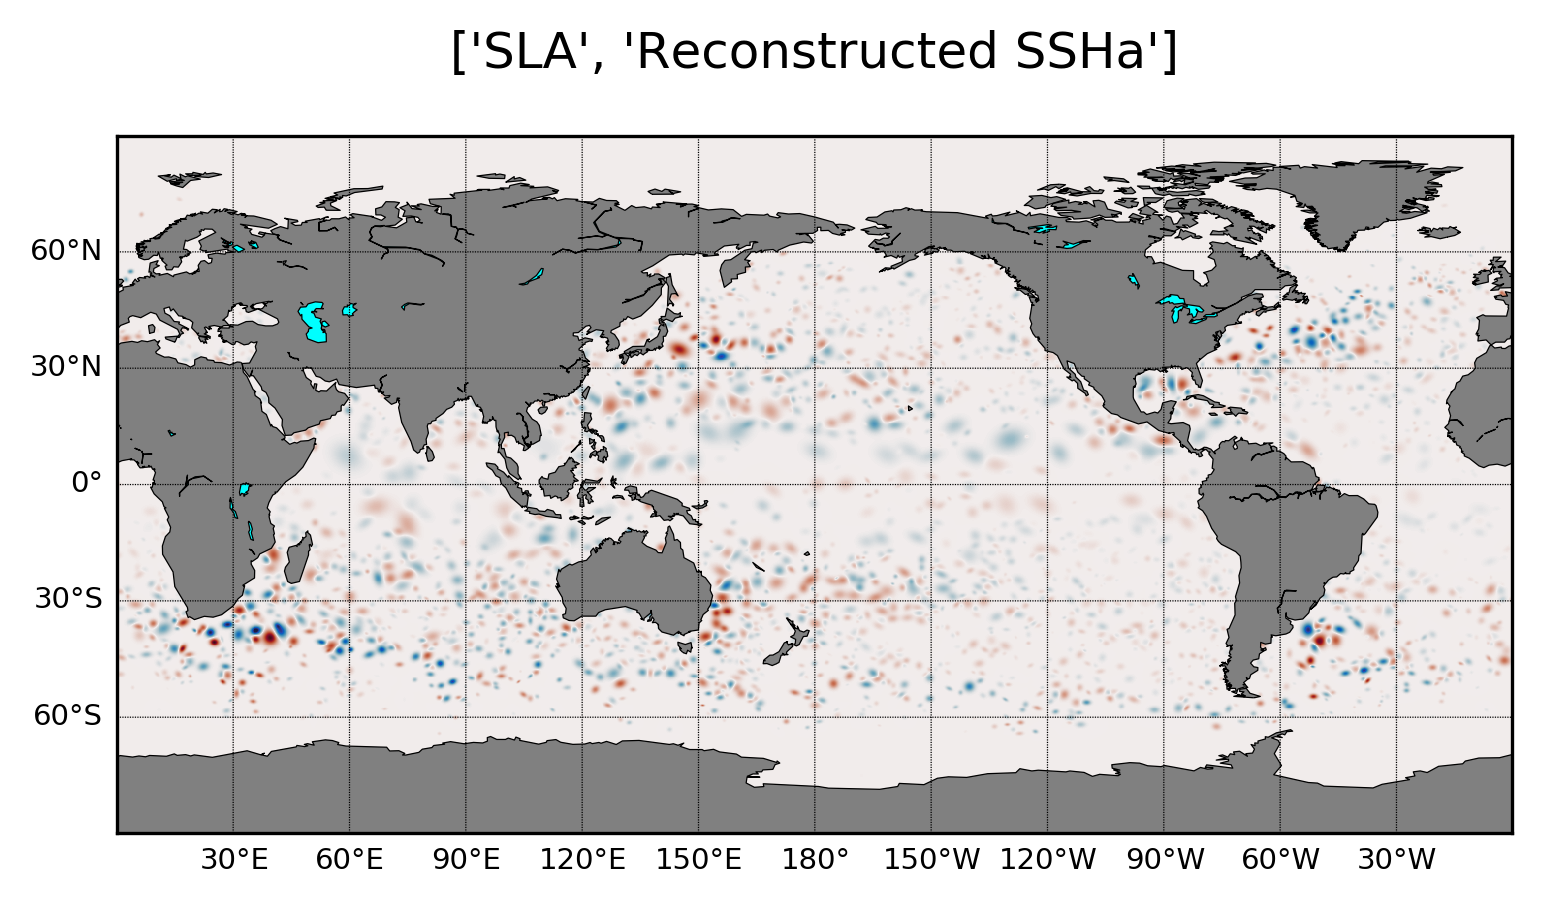

In [21]:
basemap_mplot(lon,lat,+negative_eddy_field[0,:,:]+positive_eddy_field[0,:,:],
              title=["SLA","Reconstructed SSHa"],projection='cyl',
              lat_0=-90,lon_0=-180,resolution='c',vmin=-0.80,vmax=0.80,
              cmap=cm.cm.balance,xan=1,yan=1,figsize=(6,6),fontsize=12,drawlinewidth=0.3);

## Results:
<ul>
    <li style='width:45%;display:inline-block'>
        <h3>Caviats</h3>
        <br>
        <ul>
            <li>
                The KE converges with the step used in the algorith
            </li>
            <li>
                Walltime increases linearly with the increasing number of steps.
            </li>
            <li>
                The optimization for the eddy reconstruction could be further improve.
            </li>
            <li>
                The assumption of Gaussian eddies may be violated under strong eddy-eddy, eddy-wave, or eddy-jet interactions.
            </li>
        </ul>
        <br><br><br>
    </li>
    <li style='width:45%;display:inline-block'>
        <img src="./figures/steps.pdf" alt="Ocean Model Energy" style="width: 100%;"/>
        <h5>Convergence of TEKE computed from TrackEddy reconstruction</h5>
    </li>
</ul>

## Tests - Synthetic Fields
##### Tracking Gaussian eddies interacting with each other.
![alt text](./figures/eddy_tracking_simple.gif "Tests")
##### Tracking Gaussian eddies interacting with each other and a sinusoidal background.
![alt text](./figures/eddy_tracking.gif "Tests")

<img src="./figures/ke_trends.pdf" alt="SO Trends" style="width: 100%;"/>


\begin{equation}    \underbrace{u^2+v^2}_{KE}=\underbrace{\overline{u}^2+\overline{v}^2}_{MKE}+\underbrace{\underbrace{\overline{u_e'}^2+\overline{v_e'}^2}_{TEKE}+\underbrace{u_{res}'^2+v_{res}'^2}_{TRKE}}_{TKE}
\end{equation}


<img src="./figures/trends_global.pdf" alt="TKE global trends" style="width: 100%;"/>

Global trends of transient kinetic energy from satellite observations between 1993-2018. Dots show regions where the trends are not significant according to the Pearson coefficient ($\sigma$=0.05).

### Additional information can be found at:
### https://trackeddy.readthedocs.io
### Or:
### Martínez‐Moreno, J., Hogg, A. M., Kiss, A. E., Constantinou, N. C., & Morrison, A. K. ( 2019). Kinetic energy of eddy‐like features from sea surface altimetry. Journal of Advances in Modeling Earth Systems, 11. https://doi.org/10.1029/2019MS001769

# tcoasts

In [2]:
from tcoasts import *

In [3]:
from dask.distributed import Client

In [4]:
c=Client()
c

<Client: 'tcp://127.0.0.1:43524' processes=4 threads=8, memory=33.67 GB>

<img src="./figures/tcoasts.png" alt="TKE global trends" style="width: 70%;"/>

## Motivation:
<video width="80%" controls>
    <source src="./figures/ptracer_2_rivers.mp4" type="video/mp4">
</video>

# Load data

In [5]:
folder='/g/data3/hh5/tmp/jm_eddy_lagrangian/mitgcm/run/'

In [6]:
contourfile='/g/data1a/v45/jm5970/github/ptracers/input_data/GoMCoastLine_nolagoon.xy'

In [7]:
distance=np.array([-450,-235,-90,-45,-15,0,15,45,90,235,450])

<img src="./figures/p_vectors.png" alt="TKE global trends" style="width: 70%;"/>

# Execute tcoasts main function

In [8]:
tac=tcoasts.TransportAlongCoast(folder,[-94,18],contourfile,distance=distance,length=50)

### Interpolate fields to perpendicular vectors

In [9]:
%%time
interp=tac.inter2vector(ufiles='U.*.nc',vfiles='V.*.nc',tracerfile='PTRACER01.*.nc')

/g/data1a/v45/jm5970/github/tcoasts/tcoasts/utils/decorators.py:11: Warning: Loading previous saved data.
  warnings.warn('Loading previous saved data.', Warning)


CPU times: user 63 ms, sys: 330 ms, total: 393 ms
Wall time: 890 ms


## Compute transport along the coast

In [16]:
perp2_coast=tac.perp2coast()

In [17]:
transport=tac.compute_transport()

<img src="./figures/p_vectors.png" alt="TKE global trends" style="width: 70%;"/>

Text(0.5, 1.15, 'Total Transport')

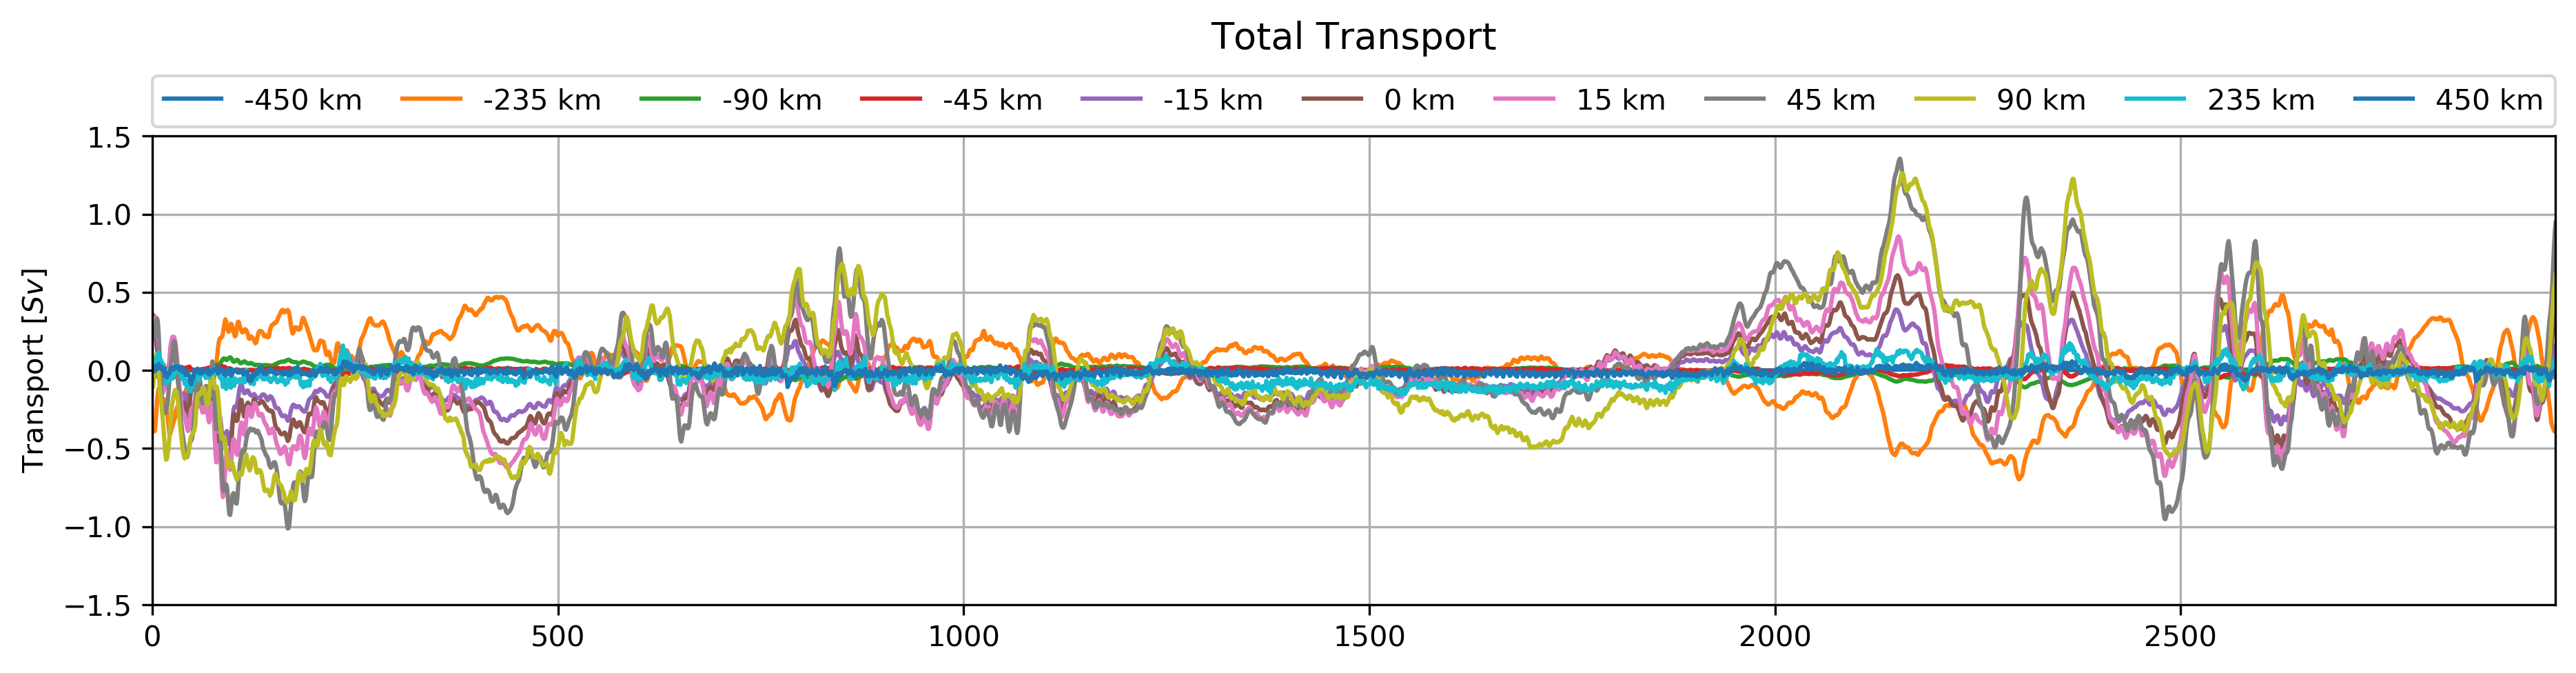

In [18]:
f,ax=plt.subplots(figsize=(15,3),dpi=300)
#(transport.sum(dim={'depth','n'})/1e6).plot.line(x='time',ax=ax,linewidth=1)

for ii in range(len(transport.transect)):
    ax.plot(transport.time,(transport/1e6).isel(transect=ii),label=str(distance[ii])+' km')

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=12, mode="expand", borderaxespad=0.)

plt.ylabel('Transport [$Sv$]')
plt.grid()
plt.xlim(transport.time[0].values,transport.time[-1].values)
plt.ylim(-1.5,1.5)
plt.title('Total Transport',y=1.15,fontsize=13)

Text(0.5, 1.15, 'Passive Tracer Transport [$C > 10\\%$]')

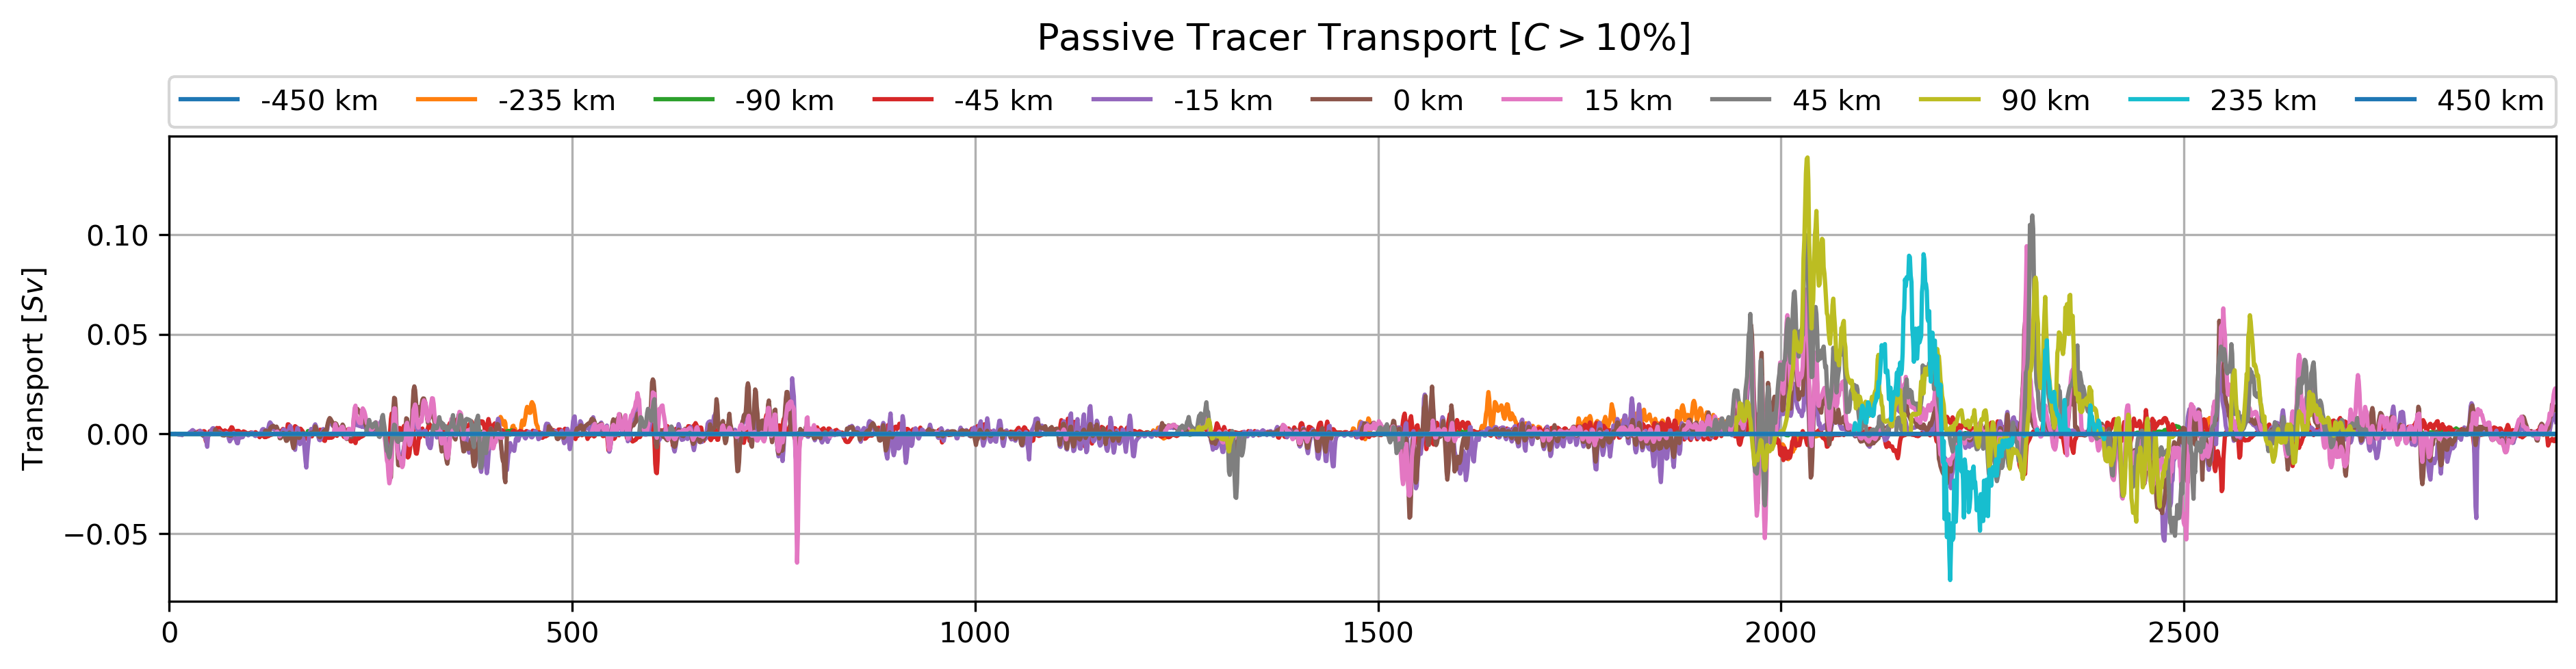

In [19]:
f,ax=plt.subplots(figsize=(15,3),dpi=300)
#(transport.sum(dim={'depth','n'})/1e6).plot.line(x='time',ax=ax,linewidth=1)
scaled_transport=tac.mask_transport(0.01,method='greater')

for ii in range(len(scaled_transport.transect)):
    ax.plot(scaled_transport.time,(scaled_transport/1e6).isel(transect=ii),label=str(distance[ii])+' km')

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=12, mode="expand", borderaxespad=0.)

plt.ylabel('Transport [$Sv$]')
plt.grid()
plt.xlim(transport.time[0].values,transport.time[-1].values)
plt.title('Passive Tracer Transport [$C > 10\%$]',y=1.15,fontsize=13)
#plt.ylim(-1.5,1.5)

# Advanced Scientific Programming in Python 
## (Europe, Asia Pacific and Latin America)

https://scipy-school.org/